# **Sentiment Analysis of Song Lyrics**

by Gregory Indick, Rasim Salimov, and Asim Kazi

Group 17



# Abstract

The goal of our project was to analyze the lyrics gathered from the Billboard Hot 100 song chart and determine whether or not that song would end up having a negative, neutral, or positive sentiment. Our data set contained lyrics from Billboard Hot 100 songs ranging from the year 2000 until 2022. Since our data set was given to us from one of our previous group mates, I will include the csv files that we used when submitting the final project so you can load them from whichever local machine you are using.

Some interesting and surpring results are as follows:


*   Songs with a positive sentiment are more likely to end up on the Billboard Hot 100 as opposed to negative songs.
*   Songs that portray stronger sentiments are more likely to appear as opposed to weak sentiments on the Billboard Hot 100

Our predictions are below:


*   Predict if a song will be positive, neutral, or negative based on their lyrics.
*   Create a scale that shows how negative or positive a song is.

Our inferences are below:


*   Achieve a way of differentiating positive and negative songs.
*   Be able to predict what makes a song negative or positive.

Our conclusion was that we were able to use the NLTK package to assign sentiment to song lyrics, which determined whether they were positive, negative or neutral. We were then able to perform Logistic Regression on our model to predict with a 0.79 accuracy what makes up a positive song, which are specific words in the song themselves. The weight of the words then determined how positive or negative that song would be.









In [ ]:
#Installs spark
%%bash 
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f4c97c8f4f0b79e23f75e57c2113766051243f9b9f708a136eb96e6af10f37fe
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
#Grabs sentiment file from hithub
%%bash

# Download the data files from github
data_file_2=sentiments.parquet

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_2} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_2} 
fi


--2022-12-08 19:30:12--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/sentiments.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56439 (55K) [application/octet-stream]
Saving to: ‘sentiments.parquet’

     0K .......... .......... .......... .......... .......... 90% 3.66M 0s
    50K .....                                                 100% 12.9M=0.01s

2022-12-08 19:30:12 (3.92 MB/s) - ‘sentiments.parquet’ saved [56439/56439]



In [ ]:
#Imports all libraries we will be using
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import split, col
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IDF
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
import glob
import subprocess
import numpy as np
import pandas as pd
from pyspark.sql.functions import when
import requests
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import io
from google.colab import files
from pathlib import Path
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
import nltk.data
nltk.download('vader_lexicon')
nltk.download('punkt')


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Sets this up for the word cloud.
%matplotlib inline

In [ ]:
#Need to grab files from local machine. 'billboard lyrics.csv' is the file to grab. It will be included in the submission.
#Once it is downloaded, run this code, and you will be able to choose 'billboard lyrics.csv' and insert it into the notebook.
from google.colab import files

uploaded = files.upload()

Saving billboard lyrics.csv to billboard lyrics.csv


# Data Pre-processing
Once we gathered our data, we had multiple different excel sheets regarding the Billboard Hot 100, including ones strictly for lyrics, genres of songs, and names of songs. We ended up only using the spreadsheet containing song lyrics, given that the rest of the data wasn't pertinent to our testing. We then removed all of the null values, which weren't many, and removed the column titled "lower lyrics" that was a duplicate column of the regular Lyrics, except all in lower case. We then had to add actual sentiment values to the lyrics, which we used the NLTK package for, and added a new column for negative, neutral, positive, and compound, which was an overall sentiment value for the song. Each new column was then given a score depending on how positive, negative, or neutral it was.

In [ ]:
#Loads file into csv and converts to panda for NLTK package to work.
billboard_lyrics = spark.read.csv("billboard lyrics.csv",header=True,inferSchema=True)
billboard_lyrics = billboard_lyrics.na.drop(subset=["Lyrics"])
billboard_lyrics.withColumnRenamed("Song Title + Aritst","Song Title + Artist").printSchema()
billboard_lyrics = billboard_lyrics.drop("Lower lyrics")
billboard_lyrics = billboard_lyrics.toPandas()
billboard_lyrics

root
 |-- Song Title + Artist: string (nullable = true)
 |-- Lower lyrics: string (nullable = true)
 |-- Lyrics: string (nullable = true)



,Song Title + Aritst,Lyrics
0,Smooth - Santana Featuring Rob Thomas,and [chorus] oh
1,Back At One - Brian McKnight,Back at One Lyrics[Verse 1] It's undeniable Th...
2,I Wanna Love You Forever - Jessica Simpson,"I Wanna Love You Forever Lyrics[Intro] Ooh, oo..."
3,My Love Is Your Love - Whitney Houston,My Love is Your Love Lyrics[Intro: Whitney Hou...
4,I Knew I Loved You - Savage Garden,"I Knew I Loved You Lyrics[Intro] Mmm Ooh, oh [..."
...,...,...
7390,Chanel - Frank Ocean,they can't hold my 7 they banned my visa
7391,Liability - Lorde,make other plans i understand
7392,Prblms - 6LACK,girl
7393,Passionfruit - Drake,"Passionfruit Lyrics[Intro: Moodymann] Hold on,..."


In [ ]:
#Uses NLTK Package to score sentiment on lyrics

#Create lists to store the different scores for each word
negative = []
neutral = []
positive = []
compound = []
#Initialize the model
sid = SentimentIntensityAnalyzer()
#Iterate for each row of lyrics and append the scores
for i in billboard_lyrics.index:
    scores = sid.polarity_scores(billboard_lyrics['Lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])
#Create 4 columns to the main data frame  for each score
billboard_lyrics['negative'] = negative
billboard_lyrics['neutral'] = neutral
billboard_lyrics['positive'] = positive
billboard_lyrics['compound'] = compound
billboard_lyrics.head()

,Song Title + Aritst,Lyrics,negative,neutral,positive,compound
0,Smooth - Santana Featuring Rob Thomas,and [chorus] oh,0.000,1.000,0.000,0.0000
1,Back At One - Brian McKnight,Back at One Lyrics[Verse 1] It's undeniable Th...,0.017,0.845,0.138,0.9884
2,I Wanna Love You Forever - Jessica Simpson,"I Wanna Love You Forever Lyrics[Intro] Ooh, oo...",0.046,0.737,0.217,0.9976
3,My Love Is Your Love - Whitney Houston,My Love is Your Love Lyrics[Intro: Whitney Hou...,0.039,0.691,0.270,0.9993
4,I Knew I Loved You - Savage Garden,"I Knew I Loved You Lyrics[Intro] Mmm Ooh, oh [...",0.042,0.682,0.276,0.9983


# Data Exploration
After our data was clean and ready to use, we decided to make some plots to have a better understanding of our data. First we made a wordcloud, which showed which words were the most popular after removing stop words. We then made two histograms, one that contained a count of different types of sentiments within our dataset, and the other contained a count of how many different word counts we had. Each had it's own distribution, but this also brought up an issue where for word counts per song, there was an issue where a lot of songs contained 50 fifty or less lyrics, leading us to believe there was an error in the data or there were a lot of songs with little lyrics.

(-0.5, 399.5, 199.5, -0.5)

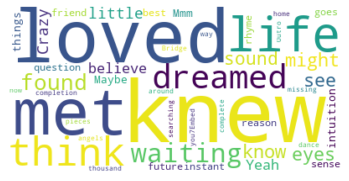

In [ ]:
#Creates wordcloud
text = billboard_lyrics['Lyrics'].iloc[4]  # first item in a Series (Column)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Chorus", "Intro","oh","ooh","Verse","Pre","Lyrics"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
x = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [ ]:
#Changes dataframe back to spark for ease of use
billboard_lyrics = spark.createDataFrame(billboard_lyrics)
billboard_lyrics.count()

7395

Text(0, 0.5, 'Counts')

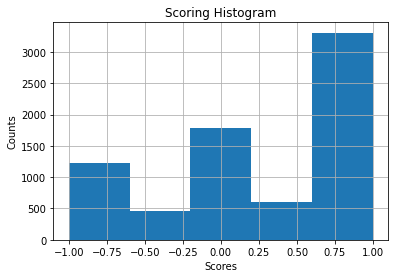

In [ ]:
#Creates a histogram that shows sentiment based on negative, neutral, or positive scoring
billboard_lyrics.toPandas().compound.hist(range=[-1,1],bins=5)
plt.title('Scoring Histogram')
plt.xlabel('Scores')
plt.ylabel('Counts')

In [ ]:
#Created a score column based on the compound column that scores sentiment on the dataframe
billboard_lyrics = billboard_lyrics.withColumn("score", \
   when((billboard_lyrics.compound < 0), lit(0)) \
     .when((billboard_lyrics.compound >= 0),lit(1)) \
      .when((billboard_lyrics.compound == 0),lit(0.5)))

In [ ]:
#Sets up the tokenizer
tokenizer = Tokenizer().setInputCol('Lyrics').setOutputCol('words')
tokenizer.transform(billboard_lyrics).show()

+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+
| Song Title + Aritst|              Lyrics|negative|neutral|positive|compound|score|               words|
+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+
|Smooth - Santana ...|     and [chorus] oh|     0.0|    1.0|     0.0|     0.0|  1.0|[, and, [chorus],...|
|Back At One - Bri...|Back at One Lyric...|   0.017|  0.845|   0.138|  0.9884|  1.0|[back, at, one, l...|
|I Wanna Love You ...|I Wanna Love You ...|   0.046|  0.737|   0.217|  0.9976|  1.0|[i, wanna, love, ...|
|My Love Is Your L...|My Love is Your L...|   0.039|  0.691|    0.27|  0.9993|  1.0|[my, love, is, yo...|
|I Knew I Loved Yo...|I Knew I Loved Yo...|   0.042|  0.682|   0.276|  0.9983|  1.0|[i, knew, i, love...|
|I Need To Know - ...|I Need to Know Ly...|   0.027|  0.885|   0.087|    0.95|  1.0|[i, need, to, kno...|
|"Hot Boyz - Missy...|hot boyz (remix) ...|   

In [ ]:
#Creates a count vectorizer for the pipeline
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(billboard_lyrics))
count_vectorizer_transformer.transform(tokenizer.transform(billboard_lyrics)).show(truncate=False)

+-------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Shows word count for lyric dataset
billboard_lyric_count = billboard_lyrics.withColumn('wordCount', fn.size(fn.split(fn.col('Lyrics'), ' ')))
billboard_lyric_count.show()

+--------------------+--------------------+--------+-------+--------+--------+-----+---------+
| Song Title + Aritst|              Lyrics|negative|neutral|positive|compound|score|wordCount|
+--------------------+--------------------+--------+-------+--------+--------+-----+---------+
|Smooth - Santana ...|     and [chorus] oh|     0.0|    1.0|     0.0|     0.0|  1.0|        4|
|Back At One - Bri...|Back at One Lyric...|   0.017|  0.845|   0.138|  0.9884|  1.0|      322|
|I Wanna Love You ...|I Wanna Love You ...|   0.046|  0.737|   0.217|  0.9976|  1.0|      382|
|My Love Is Your L...|My Love is Your L...|   0.039|  0.691|    0.27|  0.9993|  1.0|      539|
|I Knew I Loved Yo...|I Knew I Loved Yo...|   0.042|  0.682|   0.276|  0.9983|  1.0|      329|
|I Need To Know - ...|I Need to Know Ly...|   0.027|  0.885|   0.087|    0.95|  1.0|      373|
|"Hot Boyz - Missy...|hot boyz (remix) ...|   0.059|  0.846|   0.095|  0.9643|  1.0|      867|
|U Know What's Up ...|U Know What’s Up ...|   0.00

Text(0, 0.5, 'Counts')

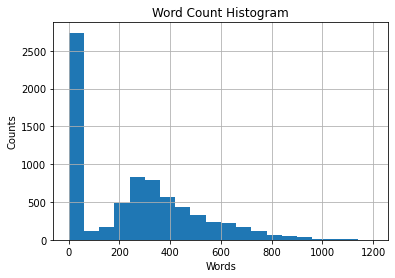

In [ ]:
#Creates histogram that shows word counts
billboard_lyric_count.toPandas().wordCount.hist(range=[0,1200],bins=20)
plt.title('Word Count Histogram')
plt.xlabel('Words')
plt.ylabel('Counts')

# Methodology
To get our methods ready for our training pipeline, we made sure to first create a count vectorizer and tokenizer to count the words of each column. We then created a stop words filter to remove any words that we didn't need. After that, we created a TF-IDF column that showed us term frequency withint our lyrics, and afterwards we made sure to create our training and test data. Lastly, we needed to create our Logistic Regression parameters to actually test and predict our model, which we would insert into our pipeline. We also created an ROC Curve to see how our data was predicting after we created our initial prediction.

In [ ]:
#Loads in the sentiment word package
sentiments_df =  spark.read.parquet('sentiments.parquet')

In [ ]:
#Creates stop words to be removed in pipeline when scoring
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [ ]:
#Creates our first pipeline
lyric_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(billboard_lyrics)
lyric_pipeline.transform(billboard_lyrics).show(5)

+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+--------------------+--------------------+
| Song Title + Aritst|              Lyrics|negative|neutral|positive|compound|score|               words|            filtered|                  tf|
+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+--------------------+--------------------+
|Smooth - Santana ...|     and [chorus] oh|     0.0|    1.0|     0.0|     0.0|  1.0|[, and, [chorus],...|    [, [chorus], oh]|(10209,[8,20,45],...|
|Back At One - Bri...|Back at One Lyric...|   0.017|  0.845|   0.138|  0.9884|  1.0|[back, at, one, l...|[lyrics[verse, 1]...|(10209,[0,1,2,3,4...|
|I Wanna Love You ...|I Wanna Love You ...|   0.046|  0.737|   0.217|  0.9976|  1.0|[i, wanna, love, ...|[wanna, love, for...|(10209,[0,1,3,4,5...|
|My Love Is Your L...|My Love is Your L...|   0.039|  0.691|    0.27|  0.9993|  1.0|[my, love, is, yo...|[love, 

In [ ]:
#Creates IDf to be used for pipeline
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [ ]:
#Creates second pipeline this time using IDF
lyric_pipeline2 = Pipeline(stages=[lyric_pipeline, idf]).fit(billboard_lyrics)
lyric_pipeline2.transform(billboard_lyrics).select('tfidf').show(1, False)
lyric_pipeline2.transform(billboard_lyrics).show(5)

+--------------------------------------------------------------------------+
|tfidf                                                                     |
+--------------------------------------------------------------------------+
|(10209,[8,20,45],[1.024118081910691,1.743974213735158,0.9810095468912375])|
+--------------------------------------------------------------------------+
only showing top 1 row

+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+--------------------+--------------------+--------------------+
| Song Title + Aritst|              Lyrics|negative|neutral|positive|compound|score|               words|            filtered|                  tf|               tfidf|
+--------------------+--------------------+--------+-------+--------+--------+-----+--------------------+--------------------+--------------------+--------------------+
|Smooth - Santana ...|     and [chorus] oh|     0.0|    1.0|     0.0|     0.0|  1.0|

In [ ]:
#Creates a dataframe that shows the shape of the dataframe
lyric_pipeline2_df = lyric_pipeline2.transform(billboard_lyrics)
print("tfidf_df shape: ", lyric_pipeline2_df.count(), len(lyric_pipeline2_df.columns))

tfidf_df shape:  7395 11


In [ ]:
#Creates scores for the most and least important words
score = pd.DataFrame({'words':lyric_pipeline2.stages[0].stages[-1].vocabulary,'score':lyric_pipeline2.stages[1].idf})
least_imp_idf = score.sort_values('score').head(5)
most_imp_idf = score.sort_values('score',ascending=False).head(5)

In [ ]:
#Shows the dataframes
display(most_imp_idf)
display(least_imp_idf)

,words,score
10208,obey,7.116935
6734,officially,7.116935
6728,lifestyles,7.116935
8857,menace,7.116935
8859,hand-me-down,7.116935


,words,score
9,[verse,0.679717
0,i'm,0.828148
1,like,0.892047
3,know,0.894690
4,just,0.908010


In [ ]:
#Split up into test, training, and validation sets
training_df, validation_df, testing_df = billboard_lyrics.randomSplit([0.6, 0.3, 0.1], seed=2022)

In [ ]:
#Shows the dataframe
training_df.limit(5).toPandas()

,Song Title + Aritst,Lyrics,negative,neutral,positive,compound,score
0,"""""Forget you"""" (Ooh",ooh),0.000,1.000,0.000,0.0000,1.0
1,"""""yeah",come on),0.000,1.000,0.000,0.0000,1.0
2,"""Burnin' Up - Faith Evans Featuring Missy """"Mi...",Burnin Up (Remix) Lyrics[Intro: P.Diddy] As we...,0.026,0.778,0.196,0.9978,1.0
3,"""Canadian Idiot - """"Weird Al"""" Yankovic""",before they see it comin' time for a pre-empt...,0.000,1.000,0.000,0.0000,1.0
4,"""God In Me - Mary Mary Featuring Kierra """"KiKi...","God In Me Lyrics[Intro: Mary Mary] (Oh, you're...",0.000,0.756,0.244,0.9994,1.0


In [ ]:
#Creates logistic regression
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

In [ ]:
#Creates a pipeline with Logistic Regression
lr_pipe = Pipeline(stages=[lyric_pipeline2, lr]).fit(training_df)

In [ ]:
#Shows the accuracy for the logistic regression pipeline
lr_pipe.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.7130782918149466|
+------------------+



In [ ]:
#Creates the vocabulary and weights to be used for scoring the words in our lyrics
vocabulary = lyric_pipeline2.stages[0].stages[-1].vocabulary
weights = lr_pipe.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'score': weights})
coeffs_df.head()

num weights: 10209
num rows: 2248


,word,score
0,i'm,-0.152853
1,like,3.703035
2,don't,2.073813
3,know,2.602934
4,just,-1.819772


In [ ]:
#Positive scores
lr_pipe_df_pos = coeffs_df.sort_values('score').head(10)

In [ ]:
#Negative scores
lr_pipe_df_neg = coeffs_df.sort_values('score', ascending=False).head(10)

In [ ]:
#Shows both scores for positive and negative
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,score
9728,itunes,54.067845
7440,"part,",42.264860
6773,"bands,",41.238825
9724,imaginary,40.569565
8788,proudly,40.014730
6464,"mess,",40.001566
6983,l.a.,38.452884
9933,i?),37.957061
9383,"circle,",37.835046
5194,paparazzi,36.816513


,word,score
7545,leave),-77.754407
9063,ridiculous,-76.993970
8628,guessin',-66.103989
8997,(goodbye),-64.411711
9647,appeared,-63.659959
6566,hesitating,-61.609856
8104,kurt,-60.847562
9677,funny?,-60.645243
6400,section,-60.638601
8046,here.,-60.087593


In [ ]:
#Creates function and gets everything you need to create ROC Curve
# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


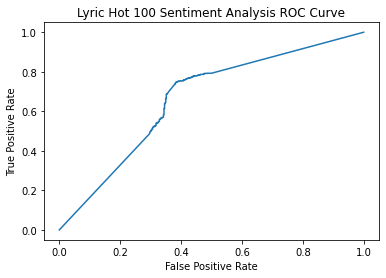

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = lr_pipe.transform(validation_df)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('score','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['score'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Lyric Hot 100 Sentiment Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
#Sets a lambda and alpha to get a better score on our logistic regression model
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [ ]:
#Creates a better pipeline with all of our models combined to get a better score
lr_pipe_3_esitimator = Pipeline(stages=[tokenizer, sw_filter, cv, idf, en_lr])

lr_pipe_3 = lr_pipe_3_esitimator.fit(training_df)

lr_pipe_3.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+-------------------------+
|avg((prediction = score))|
+-------------------------+
|       0.7962633451957295|
+-------------------------+



In [ ]:
#Stores the new pipeline infomration into two dataframes

pipe_4 = lr_pipe.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).\
    toPandas()

pipe_6 = lr_pipe_3.transform(validation_df).select(fn.avg(fn.expr('float(prediction=score)'))).\
toPandas()

pipe_4 = pipe_4.rename(columns={'avg(correct)': 'AUC Score'})

pipe_6 = pipe_6.rename(columns={'avg((prediction = score))': 'AUC Score'})

compare_1_df = pd.concat([pipe_4, pipe_6], axis=0)

compare_1_df.insert(0, "Model Names", ['LR Model 1','LR Model 2'], True)

# Conclusion
After creating our initial model, we were able to create a more accurate Logistic Regression seen below. They can both be compared to each other, with the second model having a more accurate score at predicting whether a song is positive or negative. In regards to our predictions, we were able to accurately predict with a score of 0.79 if a song would be positive or negative based in it's lyric scores. We also created a scale that showed sentiment values based off of the NLTK pacakge. For inferences, we were also able to determine what the difference would be for positive and negative songs would be by looking at the negative or positive column in our dataset. All of our summary tables and conclusions to our data are listed below.

In [ ]:
#Compares the two model scores
display(compare_1_df)

,Model Names,AUC Score
0,LR Model 1,0.713078
0,LR Model 2,0.796263


In [ ]:
#Shows the scores on the new models words
lr_weight_df = lr_pipe_3.stages[-1].coefficients.toArray()
lr_pipe_coeffs = pd.DataFrame({'word': lr_pipe_3.stages[2].vocabulary, 'score': lr_weight_df})
lr_pipe_coeffs.sort_values('score').head(15)

,word,score
6378,scare,-0.265300
6858,goneembed,-0.241816
4646,showin',-0.237270
5333,"""""heart",-0.232305
4969,greed,-0.167061
6740,ballin’,-0.161161
3884,prison,-0.158849
6793,"ugh,",-0.157740
7132,sure),-0.157630
6966,what'd,-0.153500


In [ ]:
#Shows how many coefficients are equal to 0.
lr_pipe_coeffs.query('score == 0.0').shape

(6311, 2)

In [ ]:
#Shows coeffecient score
lr_pipe_coeffs.query('score == 0.0').shape[0]/lr_pipe_coeffs.shape[0]

0.8841412160268983

In [ ]:
#Scores the new positive and negative values

weights_2 = lr_pipe_3.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df_2 = pd.DataFrame({'word': lr_pipe_3.stages[2].vocabulary, 'score': weights_2})
coeffs_df_2.head()

num weights: 10209
num rows: 2248


,word,score
0,i'm,0.000000
1,like,0.059213
2,don't,0.000000
3,know,0.000000
4,just,0.000590


In [ ]:
#Shows the score values for the new pipeline models words
lr_pipe_df_pos_1 = coeffs_df_2.sort_values('score').head(10)
lr_pipe_df_neg_1 = coeffs_df_2.sort_values('score', ascending=False).head(10)
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,score
6977,o's,0.135096
2811,belly,0.090256
6538,peak,0.088685
5,love,0.078799
3069,thanks,0.077463
4224,showing,0.077345
4458,up;,0.071792
6392,icy,0.067279
6213,design,0.066337
1528,strength,0.064681


,word,score
6378,scare,-0.265300
6858,goneembed,-0.241816
4646,showin',-0.237270
5333,"""""heart",-0.232305
4969,greed,-0.167061
6740,ballin’,-0.161161
3884,prison,-0.158849
6793,"ugh,",-0.157740
7132,sure),-0.157630
6966,what'd,-0.153500
